# Bayesian Machine Learning
## Challenges in Markov chain Monte Carlo for Bayesian neural networks : Iris dataset

#### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings
warnings.filterwarnings(action="ignore")

from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from typing import Union
from tqdm import tqdm

sys.path.append('../source/')
from HMC import HMC
from MALA import MALA, AdaptiveMALA
from RWHM import Metropolis_Hastings
from model import Model

In [2]:
seed = 42
torch.random.manual_seed(seed)
np.random.seed(seed)

### Utils

In [3]:
def log_target_factory(
        mlp: Model,
        X: Union[np.ndarray, torch.Tensor],
        y: Union[np.ndarray, torch.Tensor],
    ):

    def log_target_fn(theta):
        log_target_tensor = mlp.compute_log_target(X, y, theta)
        log_target_array = log_target_tensor.cpu().detach().numpy()
        return log_target_array

    return log_target_fn

In [4]:
def grad_log_target_factory(
        mlp: Model,
        X: Union[np.ndarray, torch.Tensor],
        y: Union[np.ndarray, torch.Tensor],
    ):

    def grad_log_target_fn(theta):
        log_target_tensor = mlp.compute_log_target(X, y, theta)
        grad_tensor = mlp.compute_grad_log_target(log_target_tensor)
        grad_array = grad_tensor.cpu().detach().numpy()
        return grad_array

    return grad_log_target_fn

In [5]:
def predict(
        mlp: Model,
        X: Union[np.ndarray, torch.Tensor],
        y: Union[np.ndarray, torch.Tensor],
        parameters_chain: Union[np.ndarray, torch.Tensor],
        return_probas: bool=False
    ):
    n_samples = len(y)
    n_classes = mlp.sizes[-1]

    y_pred = np.zeros(n_samples, dtype=int)
    y_probas = np.zeros((n_samples, n_classes))

    for i, X_i in tqdm(enumerate(X)):
        ret_i = mlp.predict(
            X_i.reshape((1, -1)),
            parameters_chain,
            return_probas=return_probas
        )

        y_proba_i = None
        if return_probas:
            y_pred_i, y_proba_i = ret_i
        else:
            y_pred_i = ret_i

        y_pred_i = y_pred_i.cpu().detach().numpy().flatten()
        y_pred[i] = y_pred_i[0]

        if y_proba_i is not None:
            y_proba_i = y_proba_i.cpu().detach().numpy().flatten()
            y_probas[i] = y_proba_i

    ret = [y_pred]
    if return_probas:
        ret += [y_probas]

    return tuple(ret)

In [6]:
def run(
    sizes,
    activations,
    X_train,
    y_train,
    X_test,
    y_test,
    N_steps=110_000,
    N_burnin=10_000,
    verbose=False,
    mh_params=dict(sigma_prop=None),
    hmc_params=dict(step_size=None, n_leapfrog=10),
    mala_params=dict(step_size=None),
    sala_params=dict(step_size=None),
    n_params_to_plot=2,
):
    samples_to_consider = (N_steps - N_burnin) // 10


    plot, n_lines, n_columns = False, 1, 1
    if n_params_to_plot > 0:
        n_columns = 4
        n_lines = (n_params_to_plot // n_columns) + int(n_params_to_plot % n_columns != 0)
        plot = True

    def do_plot(title, sample):
        if not plot:
            return
        plt.figure(figsize=(5*n_columns, 5*n_lines))
        plt.title(title)
        for i in range(n_params_to_plot):
            plt.subplot(n_lines, n_columns, i+1)
            plt.plot(sample[:, i], label=f"$\theta_{i}$")
        plt.show()

    mlp = Model(sizes, activations)
    print(mlp)

    log_target_fn = log_target_factory(mlp, X_train, y_train)
    grad_log_target_fn = log_target_factory(mlp, X_train, y_train)

    N_params = mlp.num_parameters()
    mu = np.zeros(N_params)
    sigma =  10 * np.ones(N_params)
    def prior(size):
        return np.random.multivariate_normal(mean=mu, cov=np.diag(sigma), size=size)

    theta_0 = prior(1)[0]

    print("_Prior_Sampling_".center(100).replace(" ", "=").replace("_", " "))
    sample = prior(samples_to_consider)
    do_plot("Prior Sampling", sample)
    y_pred, y_probas = predict(
        mlp, X_test, y_test, parameters_chain=sample, return_probas=True
    )
    print("\tAccuracy: ", accuracy_score(y_test, y_pred))

    print("_Hamiltonian_Monte_Carlo_".center(100).replace(" ", "=").replace("_", " "))
    HMC_sampler = HMC(
        log_target=log_target_fn, grad_log_target=grad_log_target_fn, theta_0=theta_0, **hmc_params
    )
    sample_HMC, acc_HMC = HMC_sampler.sample(N_steps, N_burnin, verbose=verbose)
    do_plot("Hamiltonian Monte Carlo", sample_HMC)
    print("\tAcceptance rate: ", acc_HMC)
    y_pred, y_probas = predict(
        mlp, X_test, y_test, parameters_chain=sample_HMC[N_steps-samples_to_consider::], return_probas=True
    )
    print("\tAccuracy: ", accuracy_score(y_test, y_pred))

    print("_Adapative_MALA_".center(100).replace(" ", "=").replace("_", " "))
    SALA_sampler = AdaptiveMALA(
        log_target=log_target_fn, grad_log_target=grad_log_target_fn, theta_0=theta_0, **sala_params
    )
    sample_SALA, acc_SALA = SALA_sampler.sample(N_steps, N_burnin, verbose=verbose)
    do_plot("Adaptive MALA", sample_SALA)
    print("\tAcceptance rate: ", acc_SALA)
    y_pred, y_probas = predict(
        mlp, X_test, y_test, parameters_chain=sample_SALA[N_steps-samples_to_consider::], return_probas=True
    )
    print("\tAccuracy: ", accuracy_score(y_test, y_pred))

    print("_MALA_".center(100).replace(" ", "=").replace("_", " "))
    if mala_params["step_size"] is None:
        mala_params["step_size"] =np.square(0.004*np.power(N_params, -0.33))
    MALA_sampler = MALA(
        log_target=log_target_fn, grad_log_target=grad_log_target_fn, theta_0=theta_0, **mala_params
    )
    sample_MALA, acc_MALA = MALA_sampler.sample(N_steps, N_burnin, verbose=verbose)
    do_plot("MALA", sample_MALA)
    print("\tAcceptance rate: ", acc_MALA)
    y_pred, y_probas = predict(
        mlp, X_test, y_test, parameters_chain=sample_MALA[N_steps-samples_to_consider::], return_probas=True
    )
    print("\tAccuracy: ", accuracy_score(y_test, y_pred))

    print("_Symmetric_Random_Walk_Metropolis_Hastings_".center(100).replace(" ", "=").replace("_", " "))
    MH_sampler = Metropolis_Hastings(
        log_target=log_target_fn, theta_0=theta_0, **mh_params
    )
    sample_MH , acc_MH = MH_sampler.sample(N_steps,N_burnin, verbose=verbose)
    do_plot("Metropolis Hastings", sample_MH)
    print("\tAcceptance rate: ", acc_MH)
    y_pred, y_probas = predict(
        mlp, X_test, y_test, parameters_chain=sample_MH[N_steps-samples_to_consider::], return_probas=True
    )
    print("\tAccuracy: ", accuracy_score(y_test, y_pred))


### Iris

In [7]:
X_iris, Y_iris = load_iris(return_X_y=True)
X_iris = X_iris
Y_iris = Y_iris
X_iris, X_iris_test, Y_iris, Y_iris_test = train_test_split(X_iris, Y_iris, test_size=0.2)

In [8]:
print(Y_iris.shape, Y_iris_test.shape)

(120,) (30,)


Model(
  (layers): ModuleList(
    (0): Linear(in_features=4, out_features=2, bias=True)
    (1): Linear(in_features=2, out_features=2, bias=True)
    (2): Linear(in_features=2, out_features=3, bias=True)
  )
  (loss): CrossEntropyLoss()
)
========================================== Prior Sampling ==========================================


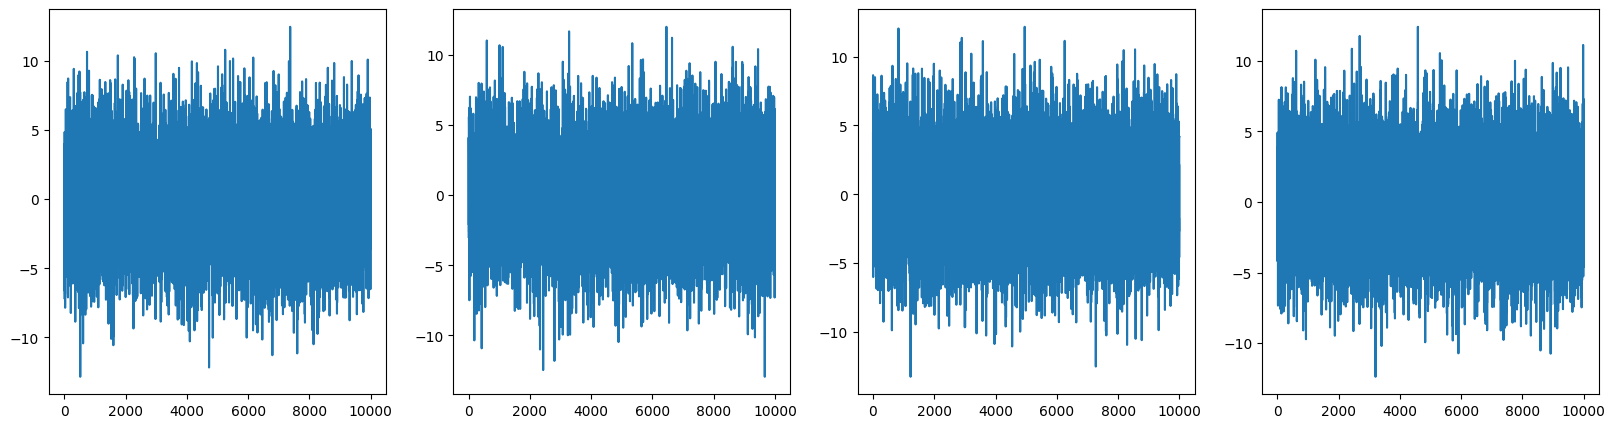

30it [01:53,  3.79s/it]


	Accuracy:  0.3
===================================== Hamiltonian Monte Carlo ======================================


100%|██████████| 110000/110000 [03:39<00:00, 500.71it/s]


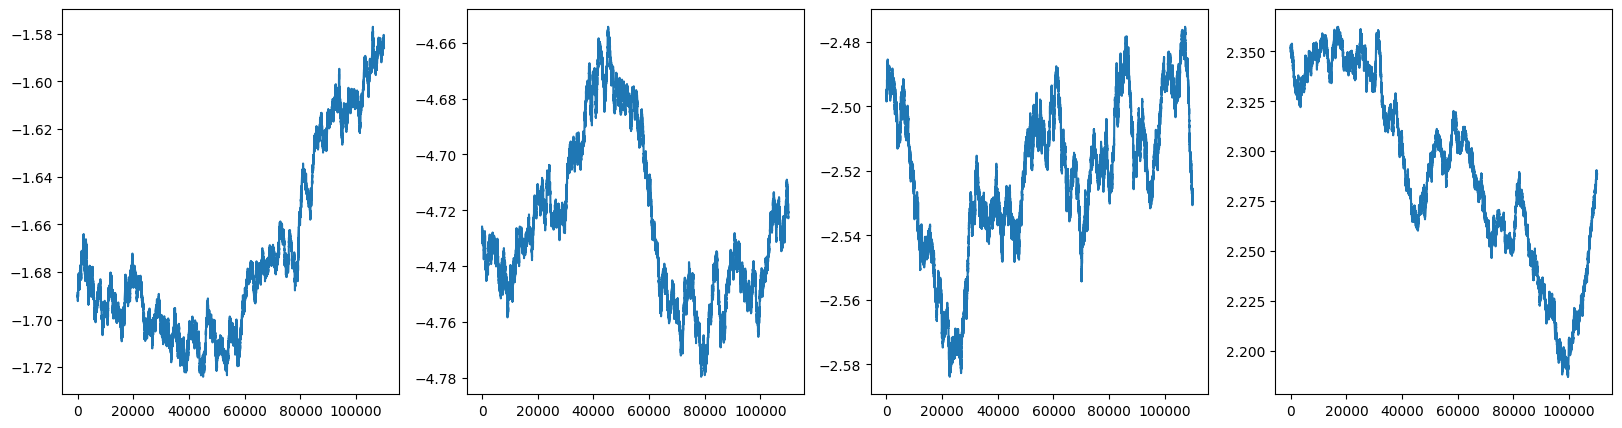

	Acceptance rate:  0.8801818181818182


30it [01:52,  3.73s/it]


	Accuracy:  0.6333333333333333
========================================== Adapative MALA ==========================================


100%|██████████| 110000/110000 [01:09<00:00, 1590.32it/s]


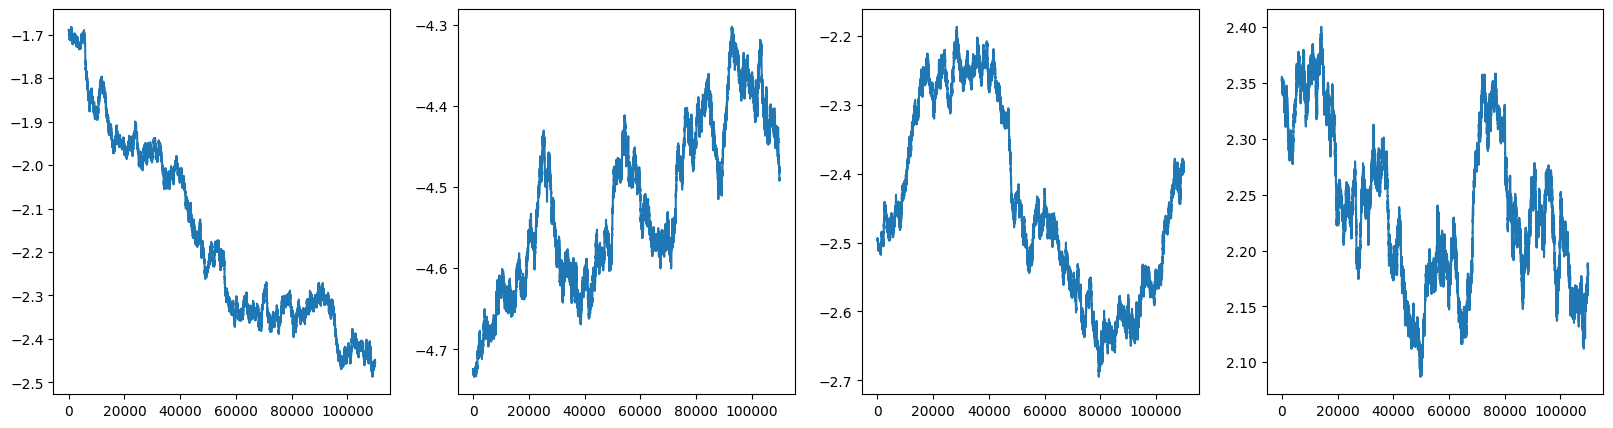

	Acceptance rate:  0.5755727272727272


30it [01:50,  3.69s/it]


	Accuracy:  0.6333333333333333
=============================================== MALA ===============================================
Running MALA sampler...


100%|██████████| 110000/110000 [01:24<00:00, 1295.04it/s]


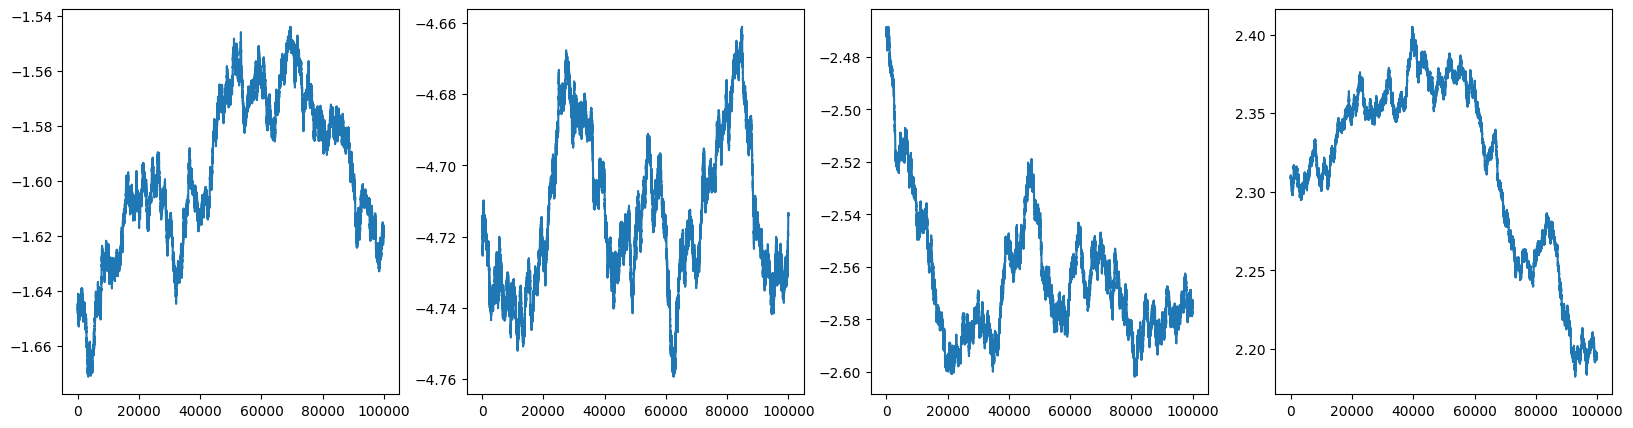

	Acceptance rate:  0.8649909090909091


30it [00:00, 2038.84it/s]


	Accuracy:  0.6333333333333333
============================ Symmetric Random Walk Metropolis Hastings =============================


100%|██████████| 110000/110000 [00:34<00:00, 3219.88it/s]


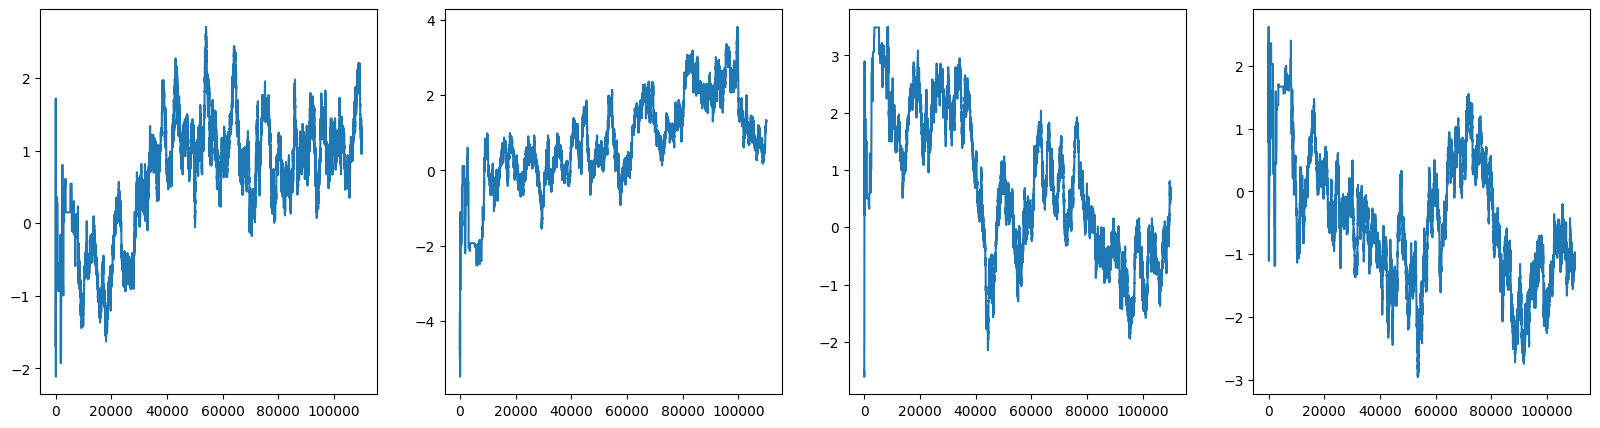

	Acceptance rate:  0.20429090909090908


30it [01:51,  3.70s/it]


	Accuracy:  1.0


In [9]:
run(
    sizes=[4, 2, 2, 3],
    activations=[nn.ReLU()] * 3 + [None],
    X_train=X_iris,
    y_train=Y_iris,
    X_test=X_iris_test,
    y_test=Y_iris_test,
    N_steps=110_000,
    N_burnin=10_000,
    verbose=False,
    hmc_params=dict(step_size=3e-5, n_leapfrog=10),
    sala_params=dict(step_size=2e-7),
    mala_params=dict(step_size=1e-7),
    n_params_to_plot=4,
)